In [ ]:
# !pip install emoji
# !pip install python-crfsuite
# !pip install Sastrawi

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger
import re
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


excelstopwords = pd.read_excel('stopwords.xlsx')
kamusalay= pd.read_csv("new_kamusalay.csv")

In [7]:
train = pd.read_csv('databagus.csv')
train = train.sample(frac=1).reset_index(drop=True)
train

,label,tweet,num_label,filtering,length
0,sadness,saya begitu besar karena telah pergi ke kelas ...,3,pergi kelas asa hilang ganti melankolis tubuh ...,51
1,fear,Saya sedang mengemudi dan berhenti di lampu me...,1,kemudi henti lampu merah rencana belok kanan b...,66
2,anger,[USERNAME] Kamu mending seperti [USERNAME] saj...,0,mending kampanye intoleran anti bineka organis...,100
3,joy,Saya akan menulis apa pun jika saya merasa ber...,2,tulis semangat tarik minat,26
4,anger,Anjir. Kenapa apkl gojek harus ada nomor telp ...,0,apkl gojek nomor telepon badan selenggara jami...,103
...,...,...,...,...,...
24647,joy,Alhamdulillah pengalaman baru bersama teman-te...,2,alhamdulillah alam teman teman minat psikometr...,87
24648,fear,@richardbranson mengaburkan penilaian Anda dal...,1,abur nilai hadap hindar,38
24649,anger,jahat banget!! buat kalian laki laki tolong jg...,0,jahat laki laki tolong suka jajan sembarang,43
24650,joy,duh sumpe ngakak hahaha jaman kalo ngetweet te...,2,aduh sumpe tertawa haha jaman mentwit via blek...,131


In [4]:
train = pd.read_csv('sedih.csv', sep=";").loc[range(0,1000)]
train

,label,tweet
0,sadness,@TWEETmeBitchess itu berbeda! Beberapa dari me...
1,sadness,Penyakit dan kematian selanjutnya dari seorang...
2,sadness,Cup Of thea sendirian dan tetap kuat cuz madu ...
3,sadness,Dia tampak sangat sedih.
4,sadness,Saya harus berhenti melihat gambar pug dan bea...
...,...,...
995,sadness,"Im kuat karena aku lemah, aku cantik karena ak..."
996,sadness,@JennaRose3xo ikuti saya & retweet saya please...
997,sadness,"Berjalan dalam kegelapan, menginjak kertas ses..."
998,sadness,Saya mengalami ini ketika nenek dari pihak ibu...


In [8]:
train['num_label'] = train['label'].map({'anger':0, 'fear':1, 'joy':2, 'love':2, 'sadness':3})
train.head()

,label,tweet,num_label,filtering,length
0,sadness,saya begitu besar karena telah pergi ke kelas ...,3,pergi kelas asa hilang ganti melankolis tubuh ...,51
1,fear,Saya sedang mengemudi dan berhenti di lampu me...,1,kemudi henti lampu merah rencana belok kanan b...,66
2,anger,[USERNAME] Kamu mending seperti [USERNAME] saj...,0,mending kampanye intoleran anti bineka organis...,100
3,joy,Saya akan menulis apa pun jika saya merasa ber...,2,tulis semangat tarik minat,26
4,anger,Anjir. Kenapa apkl gojek harus ada nomor telp ...,0,apkl gojek nomor telepon badan selenggara jami...,103


In [10]:
train.groupby(by="num_label").count()

,label,tweet,filtering,length
num_label,,,,
0,5741,5741,5741,5741
1,5633,5633,5633,5633
2,7505,7505,7505,7505
3,5773,5773,5773,5773


In [11]:
def lowercase(review):
    return review.lower() #dari python langsung, bkn dari external library

# hapus URL
def remove_url(review):
    return re.sub(r'http\S+', '', review)

def remove_hashtags(review):
    # Pola regex untuk mendeteksi hashtag
    pattern = r'#\w+'
    return re.sub(pattern, '', review)


#KAMUS ALAY
def alay(review):
    alay_dic = kamusalay.to_dict()
    alay_dic = dict(zip(kamusalay.iloc[:,0], kamusalay.iloc[:,1]))
    words = review.split()
    for i in range(len(words)):
        word = words[i]
        if word in alay_dic.keys():
            words[i] = alay_dic[word]
    sentence = " ".join(words)
    return sentence

def remove_square_brackets(review):
    # Menghapus teks di dalam kurung siku beserta kurungnya
    return re.sub(r'\[.*?\]', '', review)

# hapus irrelevant char(angka, simbol, tanda baca)
def remove_irrelevant(review):
    return re.sub('[^a-zA-Z\s]', ' ', review)

# hapus spasi lebih dari 1
def remove_space(review):
    review= re.sub(r'\s+', ' ', review)
    review= review.replace('\n', ' ')
    review= review.replace('\\n', ' ')
    review= review.replace('\t', ' ')
    review= review.replace('\\t', ' ')
    review= review.replace('\\u', ' ')
    review= review.replace('\\', ' ')
    return review

# hapus emoji
def remove_emoji(review):
    emoji_pattern= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & dingbat
                           u"\U0001F680-\U0001F6FF"  # transportasi & simbol map
                           u"\U0001F700-\U0001F77F"  # simbol kuno
                           u"\U0001F780-\U0001F7FF"  # simbol kuno tambahan
                           u"\U0001F800-\U0001F8FF"  # simbol tanda batas
                           u"\U0001F900-\U0001F9FF"  # emoticon tambahan
                           u"\U0001FA00-\U0001FA6F"  # simbol musik
                           u"\U0001FA70-\U0001FAFF"  # simbol musik tambahan
                           u"\U00002702-\U000027B0"  # simbol karakter
                           u"\U000024C2-\U0001F251"  # simbol katakter tambahan
                           "]+", flags= re.UNICODE)
    return emoji_pattern.sub(r'', review)


#REMOVING REPEAT CHARACTER
def repeat_char(review):
    review= re.sub('([A-Za-z])\\1{2,}','\\1', review)
    return review


#Remove Stopword Indo
def remove_stopwords(sentence):
#     stopwords_list = [
#     "ada", "adalah", "akan", "aku", "anda", "apa", "apakah", "atas", "atau",
#     "bagaimana", "banyak", "bahwa", "bagi", "baru", "beberapa", "belum", "bisa",
#     "bukan", "dalam", "dan", "dengan", "di", "dari", "demi", "dia", "hingga",
#     "itu", "ini", "jadi", "jika", "juga", "karena", "ke", "kita", "lagi",
#     "maka", "mereka", "oleh", "pada", "saat", "saya", "sejak", "sebagai",
#     "sedang", "sekarang", "setiap", "setelah", "tetapi", "tidak", "untuk",
#     "yang"
#     ]
    stopwords_list = list(excelstopwords['stopwords'])
    words = sentence.split()
    no_words = [w for w in words if w not in stopwords_list]
    sentence = " ".join(no_words)
    return sentence


# Create stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
# Stemming function
def stemmed(review):
    return stemmer.stem(review)



In [12]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_hashtags)
    train['filtering']= train['filtering'].apply(remove_url)
    train['filtering']= train['filtering'].apply(remove_square_brackets)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train['filtering']= train['filtering'].apply(alay)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    train['filtering']= train['filtering'].apply(stemmed)
    return train

In [21]:
train = df_prep(train)
train = train.sample(frac=1).reset_index(drop=True)
train

,label,tweet,filtering
0,sadness,Kamu tahu... Saya melakukannya dengan sangat b...,laku buruk tes
1,sadness,Sekolah menengah berjalan terlalu cepat,sekolah tengah jalan cepat
2,sadness,Ketika ibuku sakit parah dan hampir meninggal.,ibu sakit parah tinggal
3,sadness,Ketika kakek saya meninggal.,kakek tinggal
4,sadness,Emosinya kali ini tidak didorong oleh kesediha...,emosi kali dorong sedih ibu serius
...,...,...,...
995,sadness,Saya sedang tidak mood .,suasana hati
996,sadness,"Ketika saya menonton program TV yang disebut ""...",tonton program televisi planet hidup rusa ling...
997,sadness,Saya punya pacar yang tinggal beberapa kilomet...,pacar tinggal kilometer jauh rumah tulis unjun...
998,sadness,Aw.____. Saya suka bagaimana orang lain member...,aw suka orang bayi laku


In [13]:
train_split = 0.9
train_size = int(len(train['filtering'])*train_split)
traindata = train[0:train_size]
valdata = train[train_size:]

In [14]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 250
#train['length'].max()
vocab_size = 5000 #coba dikecilkan biar ga overfit len(unique())
embedding_dim = 48

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Generate the word index dictionary
tokenizer.fit_on_texts(traindata['filtering'])
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(traindata['filtering'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
])

learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])


In [16]:
num_epochs = 60
BATCH_SIZE = 128
history = model.fit(training_padded, traindata['num_label'], batch_size = BATCH_SIZE, epochs=num_epochs,
                    validation_data=(validation_padded, valdata['num_label']), verbose=2)

Epoch 1/60
174/174 - 12s - loss: 1.3829 - accuracy: 0.2900 - val_loss: 1.3783 - val_accuracy: 0.3224
Epoch 2/60
174/174 - 11s - loss: 1.3719 - accuracy: 0.3330 - val_loss: 1.3678 - val_accuracy: 0.3350
Epoch 3/60
174/174 - 11s - loss: 1.3578 - accuracy: 0.3709 - val_loss: 1.3527 - val_accuracy: 0.3865
Epoch 4/60
174/174 - 11s - loss: 1.3360 - accuracy: 0.4155 - val_loss: 1.3288 - val_accuracy: 0.4197
Epoch 5/60
174/174 - 11s - loss: 1.3058 - accuracy: 0.4606 - val_loss: 1.2976 - val_accuracy: 0.5024
Epoch 6/60
174/174 - 11s - loss: 1.2683 - accuracy: 0.5231 - val_loss: 1.2594 - val_accuracy: 0.5839
Epoch 7/60
174/174 - 12s - loss: 1.2221 - accuracy: 0.5688 - val_loss: 1.2108 - val_accuracy: 0.6119
Epoch 8/60
174/174 - 11s - loss: 1.1670 - accuracy: 0.5994 - val_loss: 1.1594 - val_accuracy: 0.6346
Epoch 9/60
174/174 - 11s - loss: 1.1111 - accuracy: 0.6299 - val_loss: 1.1072 - val_accuracy: 0.6549
Epoch 10/60
174/174 - 11s - loss: 1.0580 - accuracy: 0.6526 - val_loss: 1.0565 - val_accura

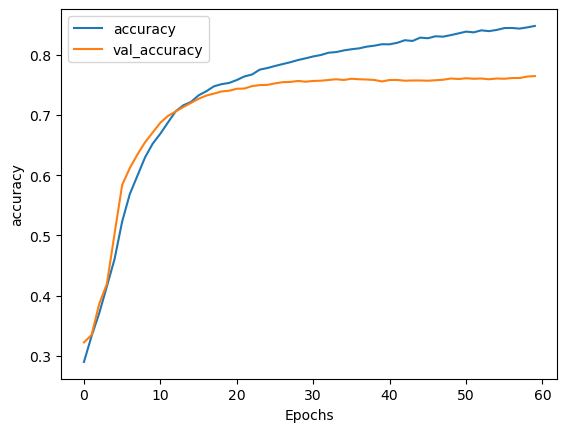

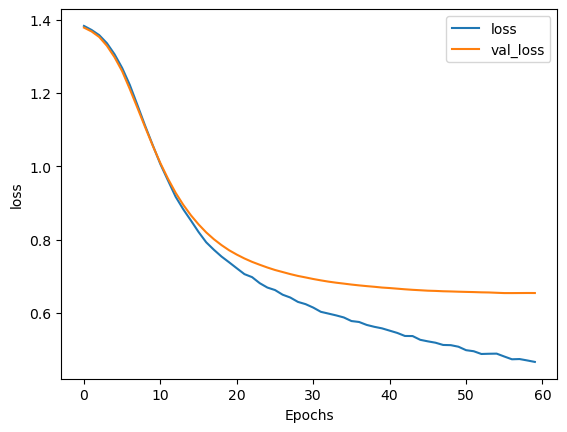

In [17]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
result = model.predict(validation_padded)
# Get the index of the maximum probability for each row
predicted_labels = np.argmax(result, axis=1)
predicted_labels

array([2, 0, 0, ..., 2, 1, 3], dtype=int64)

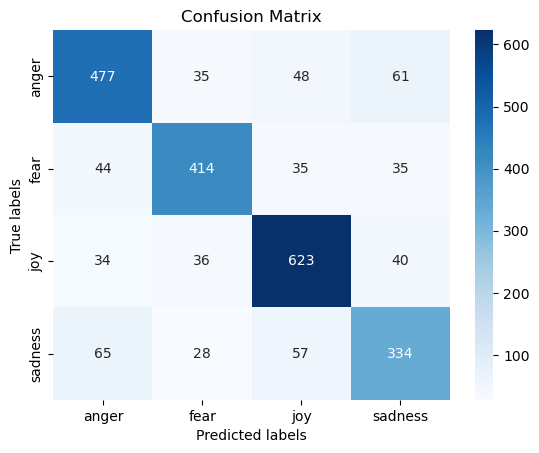

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Replace y_true and y_pred with your actual data
y_true = np.array(valdata['num_label']) # True labels
y_pred = predicted_labels  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision (macro, micro, and weighted)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Calculate recall (macro, micro, and weighted)
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score (macro, micro, and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all the metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)


Accuracy: 0.7810650887573964
Precision (Macro): 0.7758811104773893
Precision (Micro): 0.7810650887573964
Precision (Weighted): 0.7803584705506259
Recall (Macro): 0.7730553207309957
Recall (Micro): 0.7810650887573964
Recall (Weighted): 0.7810650887573964
F1 Score (Macro): 0.7743053210871861
F1 Score (Micro): 0.7810650887573964
F1 Score (Weighted): 0.7805401256594519


### VALIDATION

In [36]:
test = pd.read_excel("data_test.xlsx")
test.head()

,tweet,label
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness


In [37]:
test['num_label'] = test['label'].map({'anger':0, 'fear':1, 'happy':2, 'love':2, 'sadness':3})
test.head()

,tweet,label,num_label
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger,0
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear,1
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness,3
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy,2
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness,3


In [38]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_hashtags)
    train['filtering']= train['filtering'].apply(remove_url)
    train['filtering']= train['filtering'].apply(remove_square_brackets)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train['filtering']= train['filtering'].apply(alay)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    train['filtering']= train['filtering'].apply(stemmed)
    return train

In [39]:
test = df_prep(test)
test = test[test['filtering'] != ""].reset_index(drop=True)
test

,tweet,label,num_label,filtering
0,"Aduh, pagi-pagi udah kena macet parah di jalan...",anger,0,aduh pagi pagi kena macet parah jalan pas kant...
1,"Tadi pagi waktu gue jalan ke sekolah, tiba-tib...",fear,1,pagi jalan sekolah motor ngebut tabrak jantung...
2,Hari ini gue dapet kabar kalau temen deket gue...,sadness,3,teman pindah kota sedih sahabat pikir jarang k...
3,Pagi tadi gue bangun dan liat cuaca cerah bang...,happy,2,pagi bangun lihat cuaca cerah suasana hati lan...
4,Baru aja dapet kabar kalau proyek yang gue ker...,sadness,3,proyek kerjain bulan tolak klien sesal korban ...
5,"Tadi siang pas di mall, ada orang yang tiba-ti...",anger,0,siang pas mal orang tabrak marah marah kesal s...
6,Siang tadi gue denger ada suara keras dari dap...,fear,1,siang dengar suara keras dapur ular masuk lang...
7,Seneng banget pas liat pengumuman di kampus ka...,happy,2,senang pas lihat umum kampus skripsi terima re...
8,Pagi ini gue telat bangun karena alarm gak bun...,anger,0,pagi telat bangun alarm bunyi pas buru buru ba...
9,"Tadi sore ada suara petir gede banget, gue lan...",fear,1,sore suara petir gede langsung takut mati elek...


In [40]:
test_sequences = tokenizer.texts_to_sequences(test['filtering'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded

array([[ 430,   52,   52, ...,    0,    0,    0],
       [  52,   17,   67, ...,    0,    0,    0],
       [  14,  340,  300, ...,    0,    0,    0],
       ...,
       [  65,  655,  779, ...,    0,    0,    0],
       [1337,  132,  132, ...,    0,    0,    0],
       [  69,  104,  485, ...,    0,    0,    0]])

In [41]:
result_test = model.predict(test_padded)
predicted_labels_test = np.argmax(result_test, axis=1)
predicted_labels_test

array([0, 1, 3, 2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 3, 1, 1, 3, 2, 0, 1, 3,
       2, 0, 1, 3, 2, 0, 1, 0, 2, 0, 1, 2, 0, 3, 1, 3, 0, 0, 1, 2, 1, 0,
       1, 3, 2, 0, 1, 2, 2, 1, 1, 0, 2], dtype=int64)

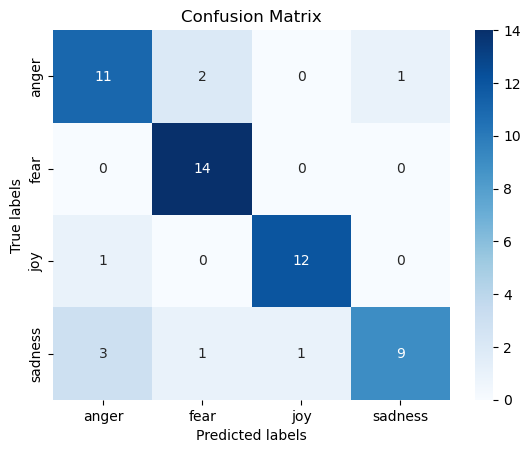

In [42]:
# Replace y_true and y_pred with your actual data
y_true = np.array(test['num_label']) # True labels
y_pred = predicted_labels_test  # Predicted labels

# Create the confusion matrix
label = ["anger", "fear", "joy", "sadness"]
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, cmap="Blues", annot = True, fmt='d', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision (macro, micro, and weighted)
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Calculate recall (macro, micro, and weighted)
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score (macro, micro, and weighted)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Print all the metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Weighted):", f1_weighted)


Accuracy: 0.8363636363636363
Precision (Macro): 0.8449849170437406
Precision (Micro): 0.8363636363636363
Precision (Weighted): 0.8435650623885919
Recall (Macro): 0.8379120879120879
Recall (Micro): 0.8363636363636363
Recall (Weighted): 0.8363636363636363
F1 Score (Macro): 0.833730854795927
F1 Score (Micro): 0.8363636363636363
F1 Score (Weighted): 0.8321063808271816


In [44]:
train.to_excel("sediihh.xlsx", index=False)